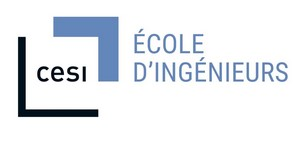

<h1 align='center'>Projet Leyenda - Livrable 2 - Traitement d'images</h1>
<h3 align='center'>Youssef AYARI, Matthieu DECLERCQ, Thomas PETAIN, Julien BARON, Jean-Baptiste CASTELLANI</h1>

## Sommaire

* [Introduction](#chapter)
* [1. Contraintes](#chapter1)
* [2. Configuration de l'environnement](#chapter2)
    * [2.1 Import des librairies Python](#section_2_1)
    * [2.2 Utilisation du GPU](#section_2_2)
* [3. Préparation du dataset](#chapter3)
    * [3.1 Création d'un jeu d'entraînement et de test](#section_3_1)
    * [3.2 Bruitage du jeu de données](#section_3_2)
* [4. Création du Modèle](#chapter4)
    * [4.1 Autoencodeur](#section_4_1)
    * [4.2 Implémentation du modèle](#section_4_2)
    * [4.3 Amélioration du modèle](#section_4_3)
* [5. Evaluation des performances de l'autoencodeur](#chapter5)
    * [5.1 Implémentation de la MSE et du SSIM](#section_5_1)
    * [5.2 Interprétation des résultats](#section_5_2)
* [6. Etude de cas](#chapter6)
    * [6.1 Chargement de l'image bruitée](#section_6_1)
    * [6.2 Débruitage de l'image](#section_6_2)
* [Conclusion](#chapter7)

## Introduction <a class="anchor" id="chapter"></a>

<div style="text-align: justify">Dans le cadre de ce projet, l'entreprise TouNum, spécialisée dans la numérisation de documents, souhaite étendre leur gamme de services pour inclure des outils de Machine Learning. En effet, leur clientèle possède une grande quantité de données à numériser au format papier. Dans le but de rester compétitive dans ce secteur d’activité, l’entreprise décide d’innover et de proposer un service de catégorisation qui serait plus que valorisable. Afin de mener à bien cette tâche, des spécialistes en Data Science du CESI ont été contactés.
<p><br>
    
<div style="text-align: justify">Dans la partie précédente nous avons classifié les photos et les autres images par le biais d'un CNN. Dans ce notebook nous aborderons le débruitage des photos afin de faciliter leur traitement par les algorithmes de Machine Learning.</div>

## 1. Contraintes <a class="anchor" id="chapter1"></a>

<div style="text-align: justify">Dans le but d'opérer une opération de débruitage nous devons réfléchir à une méthode qui nous permettra de réduire la dimension de notre image. En effet, lorsque nous traitons des images, nous avons beaucoup de caractéristiques en entrée. Prenons une image 28 x 28 pixels, dans ce cas nous aurons 784 inputs dans notre réseau de neurones avec autant de dimensions, ce qui rend le traitement et l'analyse compliqués.</div><br>

<div style="text-align: justify">Nous connaissons des méthodes permettant de réduire les dimensions de notre image. Nous pouvons citer dans un premier temps l'ACP (Analyse en Composantes Principale). Néanmoins, cette solution ne nous satisfait pas car les relations entre les caractéristiques et les points de données dans un espace à haute dimension présentent une relation non linéaire.</div><br>

<div style="text-align: justify">Dans ce cas de figure, nous pouvons alors nous tourner vers le t-SNE. Néanmoins, cet algorithme, bien que très efficace, ne convainc pas du fait qu'il reste très gourmand en ressources. Par conséquent, nous devons trouver un algorithme qui nous permet de garder une approche non linéaire tout en conservant des performances acceptables.</div><br>


## 2. Configuration de l'environnement <a class="anchor" id="chapter2"></a>

Tout comme dans le premier livrable, nous devons préparer notre environnement de travail pour mener à bien notre projet. Par conséquent, nous reviendrons sur les mêmes points qui ont été abordés précédemment : l'import des librairies Python et l'utilisation du GPU. 

### 2.1 Import des librairies Python <a class="anchor" id="section_2_1"></a>

Dans le cadre de ce second livrable, nous avons décidé d’importer plusieurs librairies Python que nous allons présenter :
<ul>
    <li style="text-align: justify"><strong>TensorFlow</strong> : est un outil open source d'apprentissage automatique développé par Google. Il est l'un des outils les plus utilisés en IA dans le domaine de l'apprentissage machine. Celui-ci contient de nombreuses implémentations de blocs nécessaire à la construction de réseaux de neurones couramment utilisés tels que des couches, des fonctions d'activation, des optimiseurs et une multitude d'outils pour faciliter le travail avec des images ou des textes afin de simplifier le codage nécessaire à l'écriture de code de réseau de neurones profond. <strong>Keras</strong> est l’API haut niveau s’exécutant sur la plateforme d’apprentissage automatique Tensorflow. Elle permet de faciliter la création et l’entraînement des modèles de deep learning.</li><br>
    <li style="text-align: justify"><strong>Scikit-image</strong> : c'est une collection d'algorithmes pour le traitement d'images. Nous l'utiliserons dans ce notebook dans le but d'évaluer les performances de
    </li>
</ul>

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
import os
import numpy as np
import pathlib
import keras.models as models
import keras.layers as layers

from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Conv2DTranspose, Dropout
from tensorflow.keras.models import Model, Sequential
from random import randrange
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers
from keras.initializers import orthogonal

from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error
from PIL import Image

### 2.2 Utilisation du GPU <a class="anchor" id="section_2_2"></a>

<div style="text-align: justify">Dans l'optique d’avoir de meilleures performances tout au long de ce projet notamment durant l’entraînement du modèle, nous avons décidé de faire passer le traitement des données par le GPU. Pour ce faire, la ligne ci-dessous nous indique si le système détecte un GPU qui peut être utilisé. (Seules les cartes Nvdia, avec Cuda installé, sont reconnues par Tensorflow).<div>

In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 3. Préparation du dataset <a class="anchor" id="chapter3"></a>

<div style="text-align: justify"> Nous avons vu dans le premier livrable comment préparer notre jeu de données pour les algorithmes de deep learning. Néanmoins, nous devrons rajouter intentionnellement du bruit sur nos images dans le but de pouvoir entraîner nos modèles dans les meilleures conditons.</div>

In [3]:
data_dir = pathlib.Path("Class")
image_h = 256
image_w = 256
batch_s = 9

### 3.1 Création des jeux d'entraînement et de test <a class="anchor" id="section_3_1"></a>

<div style="text-align: justify">Pour préparer le jeu de données, nous le séparons en deux sous-ensembles homogènes afin d'éviter la sous-représentation de classe. Le premier sous-ensemble, dit d'entraînement, permettra au modèle d'ajuster ses poids et par conséquent améliorer son débruitage. Le second nous permet d'évaluer la capacité du modèle à débruiter. C'est sur ce jeu de données qu'on se base pour le calcul de la précision du modèle.<div>   

In [4]:
# Le train_set
train_set = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  labels='inferred',
  validation_split=0.2,
  subset ="training",
  seed=42,
  image_size=(image_h, image_w),
  batch_size=batch_s,
  color_mode="rgb"
)

# Le test_set
test_set = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  labels='inferred',
  validation_split=0.2,
  subset ="validation",
  seed=42,
  image_size=(image_h, image_w),
  batch_size=batch_s,
  color_mode="rgb"
)

Found 10000 files belonging to 1 classes.
Using 8000 files for training.
Found 10000 files belonging to 1 classes.
Using 2000 files for validation.


### 3.2 Bruitage du jeu de données <a class="anchor" id="section_3_2"></a>

<div style="text-align: justify">Notre dataset ne contenant pas d'image bruitée, nous devons par conséquent ajouter un bruit gaussien aléatoire sur chaque image. Pour ce faire nous générons aléatoirement un entier que nous multiplions par un facteur et additionnons à notre image.</div>

In [5]:
#Process image 
def preprocess(data, is_batch = True):
    batch_size = len(data) if is_batch else 1
    data = np.array(data, dtype=np.float32) #Conversion de l'image en narray de nombre de flotan
    data = data.astype('float32') / 255.0 #Normalisation des données de narray
    data = np.reshape(data, (batch_size, image_h, image_w, 3))# redimensionnement de l'array
    return data

#Bruitage de l'image
def noise_it(data, noise_factor = 0.2):
    data_noisy = data + noise_factor * tf.random.normal(shape = data.shape)
    return np.clip(data_noisy, 0., 1.)#Normalisation des données après le bruitage
    
#Sépare les features des labels 
def split_dataset(data):
    for photo_batch, label_batch in data:
        photo = photo_batch
        break
    return photo

x_train = split_dataset(train_set)
x_test = split_dataset(test_set)

x_train = preprocess(x_train)
x_test = preprocess(x_test)

x_train_noisy = noise_it(x_train) 
x_test_noisy = noise_it(x_test)

Nous pouvons voir ci-dessous que les images issues de notre dataset ont bien été bruitées.

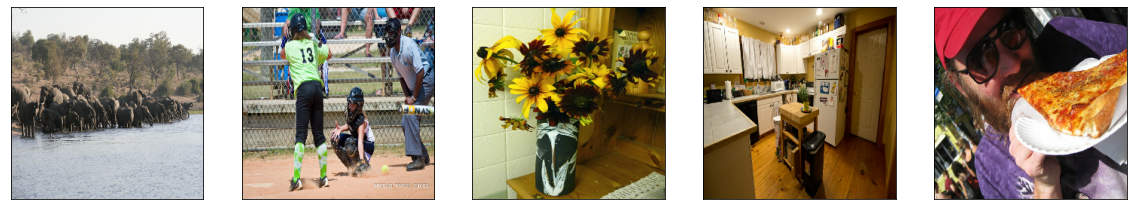

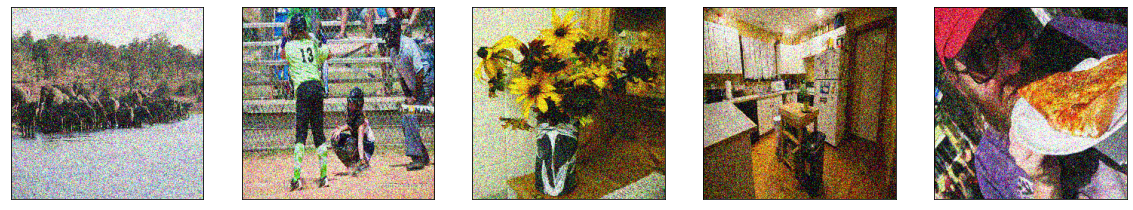

In [6]:
#Affichage d'image
def display_image(X, n, size = 20):
    plt.figure(figsize=(size, size))
    for i in range(n):
        ax = plt.subplot(1, n, i+1)
        plt.imshow(X[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

display_image(x_train,5)
display_image(x_train_noisy, 5)

## 4. Création du modèle <a class="anchor" id="chapter4"></a>

<div style="text-align: justify">Nous avons maintenant un dataset nettoyé et prêt à être exploité pour l'entraînement des modèles. Par conséquent cette partie est axée sur le développement et l'évaluation du modèle.</div>

### 4.1 Autoencodeur <a class="anchor" id = "section_4_1">

<div style="text-align: justify">Cette architecture fonctionne sur la base de 2 concepts qui nous permettront de prendre en entrée une image bruitée :</div><br>

- <strong>Encodeur</strong>: L'objectif de cette étape est de sous-échantillonner l’image en entrée. Pour ce faire, nous allons utiliser des opérations de convolution comme vues précédemment dans le livrable 1. Ce qui aura pour conséquence de réduire la taille de l’image d’entrée. A la suite des opérations de convolution, nous obtiendrons une représentation vectorielle de notre image, appelée espace latent.

- <strong>Décodeur</strong>: La seconde partie, appelée décodeur, prend en entrée l’espace latent généré par l’encodeur. Son objectif sera de reconstruire l’image en supprimant le bruit. Pour ce faire, nous utilisons des couches de convolutions transposées. Ces couches vont rééchantillonner l’image à partir des caractéristiques de l’espace latent comme le montre le schéma ci-dessous :

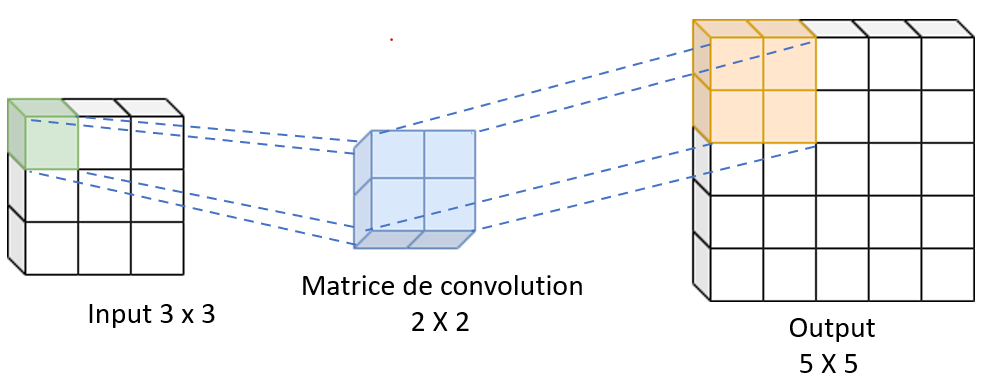
<center><em>Schéma de l'opération transposée de convolution</em></center>
<br>

<div style="text-align: justify">Cette architecture répond parfaitement à la problématique posée précédemment dans le notebook. En effet, nous avons pu diminuer la dimension de manière non-linéaire tout en gardant des performances très acceptables.</div>


### 4.2 Implémentation du modèle <a class="anchor" id = "section_4_2">

<div style="text-align: justify">Dans cette partie, nous allons implémenter le modèle d’auto-encodeur décrit précédemment. Nous définissons au préalable les variables utiles au modèle telles que le nombre d'épochs ou la taille du batch.</div>

In [7]:
nb_epochs = 1000
batch_size = 18

#### 4.2.1 Définition du modèle <a class="anchor" id = "section_5_2_1">

<div style="text-align: justify">La cellule ci-dessous représente les différentes couches de convolution et de transposé utiles à la reconstruction de l'image. Nous précisons les différentes tailles de filtre et de kernel ainsi que les fonctions d'activation.</div><br>

<div style="text-align: justify">Dans le but de minimiser notre fonction coût, nous avons choisi l'optimiseur Adam. Cet algorithme d'optimisation est utilisé pour la formation de modèles d'apprentissage profond. Il s'agit d'une extension de la descente de gradient.</div>

In [8]:
inputs = Input(shape=(image_w, image_w, 3))

#Encoder
x = Conv2D(64, (3, 3), activation="relu", padding="same")(inputs)
x = Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = MaxPooling2D((2, 2), padding="same")(x)
x = Conv2D(128, (3, 3), activation="relu", padding="same")(x)
x = MaxPooling2D((2, 2), padding="same")(x)
x = Conv2D(128, (3, 3), activation="relu", padding="same")(x)
x = Conv2D(256, (3, 3), activation="relu", padding="same")(x)
x = MaxPooling2D((2, 2), padding="same")(x)


# Decoder
x = Conv2D(256, (3, 3),  activation="relu", padding="same")(x)
x = Conv2D(128, (3, 3),  activation="relu", padding="same")(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation="relu", padding="same")(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = Model(inputs, x)
model_opt = tf.keras.optimizers.Adam()
autoencoder.compile(optimizer=model_opt, loss="binary_crossentropy")
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 128)     73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 128)       147584

#### 4.2.3 Sauvegarde du meilleur modèle  <a class="anchor" id="section_5_2_3"></a>

<div style="text-align: justify">Une fois les différentes épochs effectuées nous sauvegardons les poids du meilleur modèle obtenus durant la phase d'entraînement. Dans la suite du notebook, nous n'aurons plus qu'à charger les poids de ce modèle pour faire des prédictions.</div>

In [9]:
callback_bestmodel = tf.keras.callbacks.ModelCheckpoint(filepath='./models/new_model.h5', verbose=0, save_best_only=True)
callbacks_list = [callback_bestmodel]

#### 4.2.4 Entraînement du modèle  <a class="anchor" id="section_5_2_4"></a>

Nous pouvons désormais entraîner notre modèle en spécifiant le nombre d'épochs ainsi que la taille du batch définie au préalable. 

In [10]:
history = autoencoder.fit(
    x=x_train_noisy,
    y=x_train,
    epochs=nb_epochs,
    batch_size=batch_size,
    validation_data=(x_test_noisy, x_test),
    callbacks = callbacks_list
)

Epoch 1/1000
1/1 [==============================] - 7s 7s/step - loss: 0.6931 - val_loss: 0.6927
Epoch 2/1000
1/1 [==============================] - 0s 183ms/step - loss: 0.6891 - val_loss: 0.7000
Epoch 3/1000
1/1 [==============================] - 0s 187ms/step - loss: 0.7006 - val_loss: 0.6907
Epoch 4/1000
1/1 [==============================] - 0s 186ms/step - loss: 0.6879 - val_loss: 0.6876
Epoch 5/1000
1/1 [==============================] - 0s 183ms/step - loss: 0.6848 - val_loss: 0.6780
Epoch 6/1000
1/1 [==============================] - 0s 183ms/step - loss: 0.6725 - val_loss: 0.6589
Epoch 7/1000
1/1 [==============================] - 0s 182ms/step - loss: 0.6494 - val_loss: 0.6689
Epoch 8/1000
1/1 [==============================] - 0s 188ms/step - loss: 0.6792 - val_loss: 0.6432
Epoch 9/1000
1/1 [==============================] - 0s 184ms/step - loss: 0.6422 - val_loss: 0.7157
Epoch 10/1000
1/1 [==============================] - 0s 186ms/step - loss: 0.7704 - val_loss: 0.6302
Ep

1/1 [==============================] - 0s 188ms/step - loss: 0.5473 - val_loss: 0.5236
Epoch 83/1000
1/1 [==============================] - 0s 186ms/step - loss: 0.5442 - val_loss: 0.5326
Epoch 84/1000
1/1 [==============================] - 0s 187ms/step - loss: 0.5497 - val_loss: 0.5315
Epoch 85/1000
1/1 [==============================] - 0s 187ms/step - loss: 0.5487 - val_loss: 0.5214
Epoch 86/1000
1/1 [==============================] - 0s 189ms/step - loss: 0.5406 - val_loss: 0.5266
Epoch 87/1000
1/1 [==============================] - 0s 186ms/step - loss: 0.5445 - val_loss: 0.5285
Epoch 88/1000
1/1 [==============================] - 0s 187ms/step - loss: 0.5459 - val_loss: 0.5205
Epoch 89/1000
1/1 [==============================] - 0s 190ms/step - loss: 0.5396 - val_loss: 0.5235
Epoch 90/1000
1/1 [==============================] - 0s 189ms/step - loss: 0.5418 - val_loss: 0.5241
Epoch 91/1000
1/1 [==============================] - 0s 187ms/step - loss: 0.5418 - val_loss: 0.5214
Epoc

1/1 [==============================] - 0s 184ms/step - loss: 0.5186 - val_loss: 0.4971
Epoch 163/1000
1/1 [==============================] - 0s 184ms/step - loss: 0.5185 - val_loss: 0.4960
Epoch 164/1000
1/1 [==============================] - 0s 184ms/step - loss: 0.5178 - val_loss: 0.4960
Epoch 165/1000
1/1 [==============================] - 0s 185ms/step - loss: 0.5181 - val_loss: 0.4957
Epoch 166/1000
1/1 [==============================] - 0s 182ms/step - loss: 0.5175 - val_loss: 0.4957
Epoch 167/1000
1/1 [==============================] - 0s 181ms/step - loss: 0.5177 - val_loss: 0.4952
Epoch 168/1000
1/1 [==============================] - 0s 187ms/step - loss: 0.5173 - val_loss: 0.4944
Epoch 169/1000
1/1 [==============================] - 0s 183ms/step - loss: 0.5169 - val_loss: 0.4943
Epoch 170/1000
1/1 [==============================] - 0s 186ms/step - loss: 0.5171 - val_loss: 0.4938
Epoch 171/1000
1/1 [==============================] - 0s 186ms/step - loss: 0.5163 - val_loss: 0.

1/1 [==============================] - 0s 190ms/step - loss: 0.5115 - val_loss: 0.4897
Epoch 243/1000
1/1 [==============================] - 0s 187ms/step - loss: 0.5113 - val_loss: 0.4894
Epoch 244/1000
1/1 [==============================] - 0s 201ms/step - loss: 0.5113 - val_loss: 0.4890
Epoch 245/1000
1/1 [==============================] - 0s 183ms/step - loss: 0.5111 - val_loss: 0.4890
Epoch 246/1000
1/1 [==============================] - 0s 187ms/step - loss: 0.5109 - val_loss: 0.4891
Epoch 247/1000
1/1 [==============================] - 0s 191ms/step - loss: 0.5108 - val_loss: 0.4890
Epoch 248/1000
1/1 [==============================] - 0s 186ms/step - loss: 0.5107 - val_loss: 0.4888
Epoch 249/1000
1/1 [==============================] - 0s 188ms/step - loss: 0.5106 - val_loss: 0.4888
Epoch 250/1000
1/1 [==============================] - 0s 187ms/step - loss: 0.5105 - val_loss: 0.4894
Epoch 251/1000
1/1 [==============================] - 0s 193ms/step - loss: 0.5109 - val_loss: 0.

1/1 [==============================] - 0s 187ms/step - loss: 0.5061 - val_loss: 0.4877
Epoch 323/1000
1/1 [==============================] - 0s 189ms/step - loss: 0.5063 - val_loss: 0.4873
Epoch 324/1000
1/1 [==============================] - 0s 188ms/step - loss: 0.5061 - val_loss: 0.4879
Epoch 325/1000
1/1 [==============================] - 0s 190ms/step - loss: 0.5062 - val_loss: 0.4869
Epoch 326/1000
1/1 [==============================] - 0s 185ms/step - loss: 0.5057 - val_loss: 0.4871
Epoch 327/1000
1/1 [==============================] - 0s 189ms/step - loss: 0.5059 - val_loss: 0.4872
Epoch 328/1000
1/1 [==============================] - 0s 192ms/step - loss: 0.5054 - val_loss: 0.4876
Epoch 329/1000
1/1 [==============================] - 0s 190ms/step - loss: 0.5057 - val_loss: 0.4869
Epoch 330/1000
1/1 [==============================] - 0s 186ms/step - loss: 0.5054 - val_loss: 0.4868
Epoch 331/1000
1/1 [==============================] - 0s 185ms/step - loss: 0.5054 - val_loss: 0.

1/1 [==============================] - 0s 191ms/step - loss: 0.5019 - val_loss: 0.4864
Epoch 403/1000
1/1 [==============================] - 0s 188ms/step - loss: 0.5018 - val_loss: 0.4867
Epoch 404/1000
1/1 [==============================] - 0s 189ms/step - loss: 0.5017 - val_loss: 0.4871
Epoch 405/1000
1/1 [==============================] - 0s 189ms/step - loss: 0.5018 - val_loss: 0.4867
Epoch 406/1000
1/1 [==============================] - 0s 189ms/step - loss: 0.5019 - val_loss: 0.4870
Epoch 407/1000
1/1 [==============================] - 0s 191ms/step - loss: 0.5021 - val_loss: 0.4876
Epoch 408/1000
1/1 [==============================] - 0s 187ms/step - loss: 0.5027 - val_loss: 0.4891
Epoch 409/1000
1/1 [==============================] - 0s 190ms/step - loss: 0.5040 - val_loss: 0.4910
Epoch 410/1000
1/1 [==============================] - 0s 189ms/step - loss: 0.5067 - val_loss: 0.4909
Epoch 411/1000
1/1 [==============================] - 0s 190ms/step - loss: 0.5061 - val_loss: 0.

1/1 [==============================] - 0s 188ms/step - loss: 0.4995 - val_loss: 0.4873
Epoch 483/1000
1/1 [==============================] - 0s 197ms/step - loss: 0.4991 - val_loss: 0.4883
Epoch 484/1000
1/1 [==============================] - 0s 191ms/step - loss: 0.4992 - val_loss: 0.4872
Epoch 485/1000
1/1 [==============================] - 0s 189ms/step - loss: 0.4992 - val_loss: 0.4879
Epoch 486/1000
1/1 [==============================] - 0s 190ms/step - loss: 0.4990 - val_loss: 0.4877
Epoch 487/1000
1/1 [==============================] - 0s 188ms/step - loss: 0.4988 - val_loss: 0.4874
Epoch 488/1000
1/1 [==============================] - 0s 188ms/step - loss: 0.4990 - val_loss: 0.4882
Epoch 489/1000
1/1 [==============================] - 0s 189ms/step - loss: 0.4990 - val_loss: 0.4871
Epoch 490/1000
1/1 [==============================] - 0s 190ms/step - loss: 0.4988 - val_loss: 0.4879
Epoch 491/1000
1/1 [==============================] - 0s 193ms/step - loss: 0.4989 - val_loss: 0.

1/1 [==============================] - 0s 189ms/step - loss: 0.4979 - val_loss: 0.4888
Epoch 563/1000
1/1 [==============================] - 0s 191ms/step - loss: 0.4975 - val_loss: 0.4885
Epoch 564/1000
1/1 [==============================] - 0s 189ms/step - loss: 0.4971 - val_loss: 0.4887
Epoch 565/1000
1/1 [==============================] - 0s 190ms/step - loss: 0.4972 - val_loss: 0.4888
Epoch 566/1000
1/1 [==============================] - 0s 199ms/step - loss: 0.4975 - val_loss: 0.4890
Epoch 567/1000
1/1 [==============================] - 0s 191ms/step - loss: 0.4975 - val_loss: 0.4886
Epoch 568/1000
1/1 [==============================] - 0s 194ms/step - loss: 0.4972 - val_loss: 0.4885
Epoch 569/1000
1/1 [==============================] - 0s 193ms/step - loss: 0.4970 - val_loss: 0.4887
Epoch 570/1000
1/1 [==============================] - 0s 191ms/step - loss: 0.4970 - val_loss: 0.4888
Epoch 571/1000
1/1 [==============================] - 0s 190ms/step - loss: 0.4972 - val_loss: 0.

1/1 [==============================] - 0s 192ms/step - loss: 0.4957 - val_loss: 0.4908
Epoch 643/1000
1/1 [==============================] - 0s 190ms/step - loss: 0.4958 - val_loss: 0.4895
Epoch 644/1000
1/1 [==============================] - 0s 189ms/step - loss: 0.4957 - val_loss: 0.4898
Epoch 645/1000
1/1 [==============================] - 0s 194ms/step - loss: 0.4958 - val_loss: 0.4901
Epoch 646/1000
1/1 [==============================] - 0s 189ms/step - loss: 0.4956 - val_loss: 0.4906
Epoch 647/1000
1/1 [==============================] - 0s 192ms/step - loss: 0.4956 - val_loss: 0.4896
Epoch 648/1000
1/1 [==============================] - 0s 191ms/step - loss: 0.4956 - val_loss: 0.4897
Epoch 649/1000
1/1 [==============================] - 0s 190ms/step - loss: 0.4955 - val_loss: 0.4903
Epoch 650/1000
1/1 [==============================] - 0s 190ms/step - loss: 0.4955 - val_loss: 0.4903
Epoch 651/1000
1/1 [==============================] - 0s 191ms/step - loss: 0.4955 - val_loss: 0.

1/1 [==============================] - 0s 190ms/step - loss: 0.4949 - val_loss: 0.4910
Epoch 723/1000
1/1 [==============================] - 0s 191ms/step - loss: 0.4946 - val_loss: 0.4913
Epoch 724/1000
1/1 [==============================] - 0s 191ms/step - loss: 0.4945 - val_loss: 0.4921
Epoch 725/1000
1/1 [==============================] - 0s 189ms/step - loss: 0.4946 - val_loss: 0.4912
Epoch 726/1000
1/1 [==============================] - 0s 188ms/step - loss: 0.4946 - val_loss: 0.4915
Epoch 727/1000
1/1 [==============================] - 0s 192ms/step - loss: 0.4946 - val_loss: 0.4919
Epoch 728/1000
1/1 [==============================] - 0s 191ms/step - loss: 0.4945 - val_loss: 0.4913
Epoch 729/1000
1/1 [==============================] - 0s 191ms/step - loss: 0.4944 - val_loss: 0.4914
Epoch 730/1000
1/1 [==============================] - 0s 188ms/step - loss: 0.4943 - val_loss: 0.4919
Epoch 731/1000
1/1 [==============================] - 0s 191ms/step - loss: 0.4944 - val_loss: 0.

1/1 [==============================] - 0s 189ms/step - loss: 0.4937 - val_loss: 0.4943
Epoch 803/1000
1/1 [==============================] - 0s 191ms/step - loss: 0.4938 - val_loss: 0.4927
Epoch 804/1000
1/1 [==============================] - 0s 190ms/step - loss: 0.4941 - val_loss: 0.4934
Epoch 805/1000
1/1 [==============================] - 0s 190ms/step - loss: 0.4937 - val_loss: 0.4949
Epoch 806/1000
1/1 [==============================] - 0s 192ms/step - loss: 0.4942 - val_loss: 0.4918
Epoch 807/1000
1/1 [==============================] - 0s 191ms/step - loss: 0.4946 - val_loss: 0.4947
Epoch 808/1000
1/1 [==============================] - 0s 192ms/step - loss: 0.4943 - val_loss: 0.4949
Epoch 809/1000
1/1 [==============================] - 0s 194ms/step - loss: 0.4947 - val_loss: 0.4932
Epoch 810/1000
1/1 [==============================] - 0s 192ms/step - loss: 0.4947 - val_loss: 0.4942
Epoch 811/1000
1/1 [==============================] - 0s 192ms/step - loss: 0.4948 - val_loss: 0.

1/1 [==============================] - 0s 202ms/step - loss: 0.4926 - val_loss: 0.4945
Epoch 883/1000
1/1 [==============================] - 0s 190ms/step - loss: 0.4926 - val_loss: 0.4946
Epoch 884/1000
1/1 [==============================] - 0s 190ms/step - loss: 0.4926 - val_loss: 0.4947
Epoch 885/1000
1/1 [==============================] - 0s 205ms/step - loss: 0.4926 - val_loss: 0.4950
Epoch 886/1000
1/1 [==============================] - 0s 191ms/step - loss: 0.4926 - val_loss: 0.4942
Epoch 887/1000
1/1 [==============================] - 0s 192ms/step - loss: 0.4927 - val_loss: 0.4956
Epoch 888/1000
1/1 [==============================] - 0s 194ms/step - loss: 0.4928 - val_loss: 0.4942
Epoch 889/1000
1/1 [==============================] - 0s 193ms/step - loss: 0.4930 - val_loss: 0.4965
Epoch 890/1000
1/1 [==============================] - 0s 191ms/step - loss: 0.4934 - val_loss: 0.4949
Epoch 891/1000
1/1 [==============================] - 0s 193ms/step - loss: 0.4942 - val_loss: 0.

1/1 [==============================] - 0s 190ms/step - loss: 0.4926 - val_loss: 0.4948
Epoch 963/1000
1/1 [==============================] - 0s 191ms/step - loss: 0.4924 - val_loss: 0.4958
Epoch 964/1000
1/1 [==============================] - 0s 192ms/step - loss: 0.4920 - val_loss: 0.4972
Epoch 965/1000
1/1 [==============================] - 0s 192ms/step - loss: 0.4922 - val_loss: 0.4944
Epoch 966/1000
1/1 [==============================] - 0s 192ms/step - loss: 0.4926 - val_loss: 0.4964
Epoch 967/1000
1/1 [==============================] - 0s 193ms/step - loss: 0.4922 - val_loss: 0.4970
Epoch 968/1000
1/1 [==============================] - 0s 190ms/step - loss: 0.4921 - val_loss: 0.4943
Epoch 969/1000
1/1 [==============================] - 0s 190ms/step - loss: 0.4923 - val_loss: 0.4967
Epoch 970/1000
1/1 [==============================] - 0s 192ms/step - loss: 0.4921 - val_loss: 0.4965
Epoch 971/1000
1/1 [==============================] - 0s 193ms/step - loss: 0.4921 - val_loss: 0.

#### 4.2.5 Visualisation des résultats <a class="anchor" id="section_5_2_4"></a>

<div style="text-align: justify">La visualisation des résultats est une partie très importante, car elle permet de nous donner des indications sur les performances du modèle.</div>

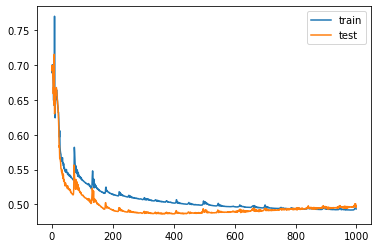

In [11]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

<div style="text-align: justify">Les courbes ci-dessus représentent l'évolution de la fonction de perte au cours des épochs pour les jeux d'entraînement et de test. Nous pouvons constater que les deux courbes se confondent au fil des épochs. Nous pouvons, par conséquent, en déduire que notre modèle ne sur-apprend pas. </div>

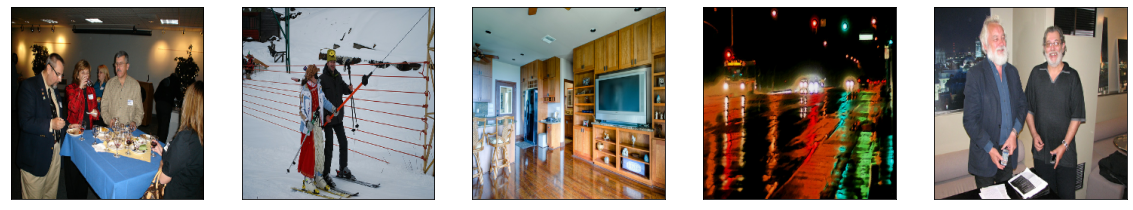

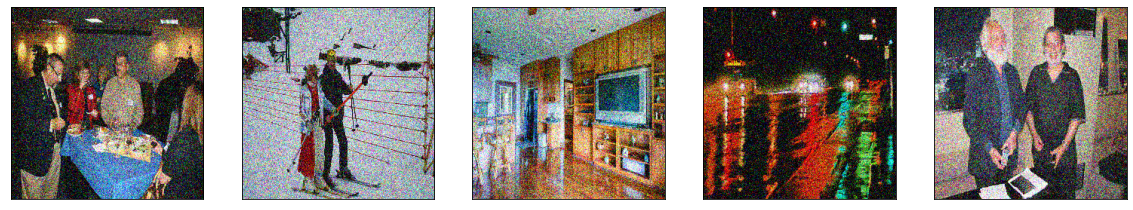

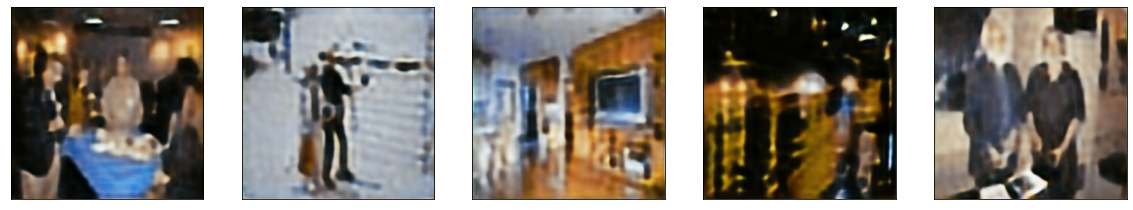

In [12]:
model_dir = pathlib.Path("models//best_model.h5")
model = keras.models.load_model(model_dir)
predictions = model.predict(x_test_noisy)
display_image(x_test, 5)
display_image(x_test_noisy, 5)
display_image(predictions, 5)

<div style="text-align: justify">Les images qui sont affichées sont le résultat de notre opération de débruitage. Le résultat visuel de notre modèle pouvant être amélioré, nous avons cherché un moyen de le rendre plus performant. Pour ce faire, nous avons cherché dans la littérature des architectures capables de produire un résultat qui s'approche plus de nos critères en termes de qualité.</div> 

### 4.3 Amélioration du modèle <a class="anchor" id="section_4_3"></a>

<div style="text-align: justify">Comme dit précédemment cette partie a pour but d'augmenter la qualité de nos résultats. Pour cela, nous avons choisi d'implémenter une architecture de DAE (Denoising AutoEncoder) tirée de la littérature.</div> 

#### 4.3.1 Définition des layers <a class="anchor" id="section_5_3_1"></a>

<div style="text-align: justify">Nous définissons les différents layers qui composent le réseau de neurones de l'autoencodeur. Dans cette architecture, nous utilisons une fonction d'activation leaky Relu ainsi que la méthode de batch normalization qui sont pertinentes à expliquer.</div><br>

<div style="text-align: justify"><strong>Leaky Relu:</strong> Il s'agit d'une fonction d'activation qui se base sur RELU, mais elle a une petite pente pour les valeurs négatives au lieu d'une pente plate. Le coefficient de pente est déterminé avant l'entraînement et ajuster au cours des époques. Comme le montre la représentation ci-dessous.</div> 

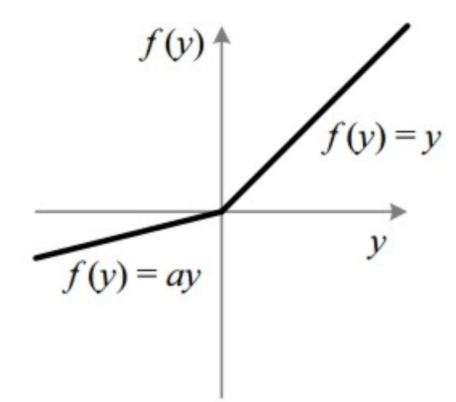
<center><em>Représentation de la fonction d'activation Leaky Relu</em></center>
<br>
<div style="text-align: justify"><strong>Batch Normalization:</strong> Il s'agit d'une méthode utilisée pour rendre le réseau de neurones artificiels plus rapide et plus stable en normalisant les données à l'entrée des couches.</div> 

In [13]:
#Encodeur
def Conv2DLayer(x, filters, kernel, strides, padding, block_id, kernel_init=orthogonal()):
    prefix = f'block_{block_id}_'
    x = Conv2D(filters, kernel_size=kernel, strides=strides, padding=padding,
                      kernel_initializer=kernel_init, name=prefix+'conv')(x)
    x = layers.LeakyReLU(name=prefix+'lrelu')(x)
    x = layers.Dropout(0.2, name=prefix+'drop')((x))
    x = layers.BatchNormalization(name=prefix+'conv_bn')(x)
    return x

<div style="text-align: justify"><strong>Conv2DTranspose()</strong> est une opération de convolution dont le noyau est appris (tout comme l'opération conv2d normale) lors de l'entraînement de notre modèle. L'utilisation de Conv2DTranspose suréchantillonnera également son entrée, mais la principale différence est que le modèle doit apprendre quel est le meilleur suréchantillonnage pour sa tâche.</div>

In [14]:
#Décodeur
def Transpose_Conv2D(x, filters, kernel, strides, padding, block_id, kernel_init=orthogonal()):
    prefix = f'block_{block_id}_'
    x = Conv2DTranspose(filters, kernel_size=kernel, strides=strides, padding=padding,
                               kernel_initializer=kernel_init, name=prefix+'de-conv')(x)
    x = layers.LeakyReLU(name=prefix+'lrelu')(x)
    x = layers.Dropout(0.2, name=prefix+'drop')((x))
    x = layers.BatchNormalization(name=prefix+'conv_bn')(x)
    return x

#### 4.3.2 Définition du modèle  <a class="anchor" id="section_5_3_2"></a>

Nous définissons et entraînons notre modèle de la même manière que le précedent. 

In [15]:
def AutoEncoder(input_shape):
    inputs = Input(shape=input_shape)
    
    # 256 x 256
    conv1 = Conv2DLayer(inputs, 64, 3, strides=1, padding='same', block_id=1)
    conv2 = Conv2DLayer(conv1, 64, 3, strides=2, padding='same', block_id=2)
    
    # 128 x 128
    conv3 = Conv2DLayer(conv2, 128, 5, strides=2, padding='same', block_id=3)
    
    # 64 x 64
    conv4 = Conv2DLayer(conv3, 128, 3, strides=1, padding='same', block_id=4)
    conv5 = Conv2DLayer(conv4, 256, 5, strides=2, padding='same', block_id=5)
    
    # 32 x 32
    conv6 = Conv2DLayer(conv5, 512, 3, strides=2, padding='same', block_id=6)
    
    # 16 x 16
    deconv1 = Transpose_Conv2D(conv6, 512, 3, strides=2, padding='same', block_id=7)
    
    # 32 x 32
    skip1 = layers.concatenate([deconv1, conv5], name='skip1')
    conv7 = Conv2DLayer(skip1, 256, 3, strides=1, padding='same', block_id=8)
    deconv2 = Transpose_Conv2D(conv7, 128, 3, strides=2, padding='same', block_id=9)
    
    # 64 x 64
    skip2 = layers.concatenate([deconv2, conv3], name='skip2')
    conv8 = Conv2DLayer(skip2, 128, 5, strides=1, padding='same', block_id=10)
    deconv3 = Transpose_Conv2D(conv8, 64, 3, strides=2, padding='same', block_id=11)
    
    # 128 x 128
    skip3 = layers.concatenate([deconv3, conv2], name='skip3')
    conv9 = Conv2DLayer(skip3, 64, 5, strides=1, padding='same', block_id=12)
    deconv4 = Transpose_Conv2D(conv9, 64, 3, strides=2, padding='same', block_id=13)
    
    # 256 x 256
    skip3 = layers.concatenate([deconv4, conv1])
    conv10 = layers.Conv2D(3, 3, strides=1, padding='same', activation='sigmoid',
                       kernel_initializer=orthogonal(), name='final_conv')(skip3)

    
    return models.Model(inputs=inputs, outputs=conv10)

model = AutoEncoder((image_h, image_w, 3))
model_opt = tf.keras.optimizers.Adam(learning_rate=0.002)
model.compile(optimizer=model_opt, loss='binary_crossentropy', metrics=['accuracy'])

Dans le but de donner un meilleur aperçu du modèle mis en place, nous pouvons nous référer au schéma ci-dessous :

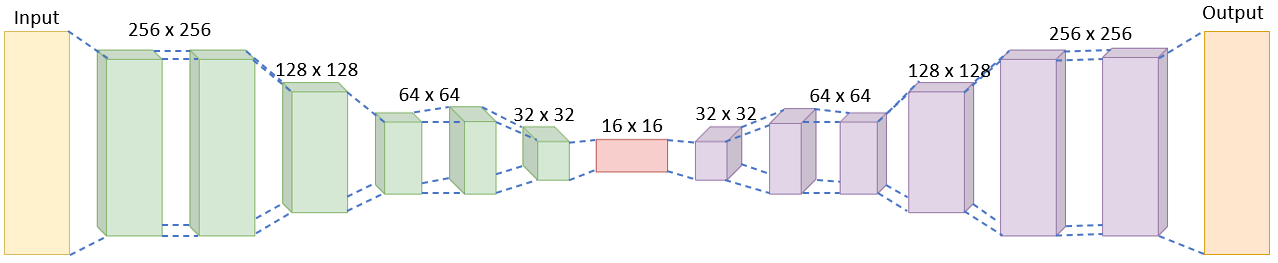
<center><em>Schéma de notre autoencodeur</em></center>

#### 4.3.3 Sauvegarde du meilleur modèle  <a class="anchor" id="section_5_3_3"></a>

In [16]:
callback_bestmodel_improved = tf.keras.callbacks.ModelCheckpoint(filepath=pathlib.Path("models_improved//new_model.h5"), verbose=0, save_best_only=True)
callbacks_list_improved = [callback_bestmodel_improved]

#### 4.3.3 Entraînement du modèle <a class="anchor" id="section_5_3_3"></a>

In [17]:
history = model.fit(
    x=x_train_noisy,
    y=x_train,
    epochs=nb_epochs,
    batch_size=18,
    shuffle=True,
    validation_data=(x_test_noisy, x_test),
    callbacks = callbacks_list_improved
)

Epoch 1/1000
1/1 [==============================] - 5s 5s/step - loss: 0.7711 - accuracy: 0.3916 - val_loss: 0.6859 - val_accuracy: 0.4205
Epoch 2/1000
1/1 [==============================] - 0s 392ms/step - loss: 0.5831 - accuracy: 0.4192 - val_loss: 0.9428 - val_accuracy: 0.4429
Epoch 3/1000
1/1 [==============================] - 0s 397ms/step - loss: 0.5790 - accuracy: 0.4199 - val_loss: 0.9722 - val_accuracy: 0.3874
Epoch 4/1000
1/1 [==============================] - 0s 397ms/step - loss: 0.5765 - accuracy: 0.4624 - val_loss: 12.1371 - val_accuracy: 0.2961
Epoch 5/1000
1/1 [==============================] - 0s 401ms/step - loss: 0.5537 - accuracy: 0.4866 - val_loss: 48.5505 - val_accuracy: 0.2957
Epoch 6/1000
1/1 [==============================] - 0s 397ms/step - loss: 0.5447 - accuracy: 0.4984 - val_loss: 123.0869 - val_accuracy: 0.2954
Epoch 7/1000
1/1 [==============================] - 0s 396ms/step - loss: 0.5409 - accuracy: 0.5022 - val_loss: 206.4043 - val_accuracy: 0.2953
Epo

Epoch 58/1000
1/1 [==============================] - 0s 404ms/step - loss: 0.5065 - accuracy: 0.6087 - val_loss: 2.2868 - val_accuracy: 0.4564
Epoch 59/1000
1/1 [==============================] - 0s 398ms/step - loss: 0.5063 - accuracy: 0.6116 - val_loss: 1.9671 - val_accuracy: 0.4605
Epoch 60/1000
1/1 [==============================] - 0s 395ms/step - loss: 0.5060 - accuracy: 0.6135 - val_loss: 1.6344 - val_accuracy: 0.4618
Epoch 61/1000
1/1 [==============================] - 0s 400ms/step - loss: 0.5059 - accuracy: 0.6146 - val_loss: 1.5008 - val_accuracy: 0.4636
Epoch 62/1000
1/1 [==============================] - 0s 395ms/step - loss: 0.5057 - accuracy: 0.6164 - val_loss: 1.3998 - val_accuracy: 0.4677
Epoch 63/1000
1/1 [==============================] - 0s 396ms/step - loss: 0.5055 - accuracy: 0.6174 - val_loss: 1.2563 - val_accuracy: 0.4721
Epoch 64/1000
1/1 [==============================] - 0s 397ms/step - loss: 0.5053 - accuracy: 0.6202 - val_loss: 1.1332 - val_accuracy: 0.4785

1/1 [==============================] - 0s 400ms/step - loss: 0.5001 - accuracy: 0.6711 - val_loss: 0.6113 - val_accuracy: 0.5094
Epoch 116/1000
1/1 [==============================] - 0s 394ms/step - loss: 0.5000 - accuracy: 0.6740 - val_loss: 0.6077 - val_accuracy: 0.5097
Epoch 117/1000
1/1 [==============================] - 0s 392ms/step - loss: 0.4999 - accuracy: 0.6716 - val_loss: 0.6081 - val_accuracy: 0.5092
Epoch 118/1000
1/1 [==============================] - 0s 396ms/step - loss: 0.4998 - accuracy: 0.6704 - val_loss: 0.6103 - val_accuracy: 0.5078
Epoch 119/1000
1/1 [==============================] - 0s 397ms/step - loss: 0.4998 - accuracy: 0.6734 - val_loss: 0.6106 - val_accuracy: 0.5070
Epoch 120/1000
1/1 [==============================] - 0s 399ms/step - loss: 0.4997 - accuracy: 0.6762 - val_loss: 0.6086 - val_accuracy: 0.5065
Epoch 121/1000
1/1 [==============================] - 0s 395ms/step - loss: 0.4997 - accuracy: 0.6792 - val_loss: 0.6059 - val_accuracy: 0.5059
Epoch 1

Epoch 172/1000
1/1 [==============================] - 0s 394ms/step - loss: 0.4973 - accuracy: 0.7188 - val_loss: 0.5925 - val_accuracy: 0.5059
Epoch 173/1000
1/1 [==============================] - 0s 392ms/step - loss: 0.4973 - accuracy: 0.7184 - val_loss: 0.5919 - val_accuracy: 0.5059
Epoch 174/1000
1/1 [==============================] - 0s 391ms/step - loss: 0.4972 - accuracy: 0.7216 - val_loss: 0.5918 - val_accuracy: 0.5059
Epoch 175/1000
1/1 [==============================] - 0s 395ms/step - loss: 0.4973 - accuracy: 0.7209 - val_loss: 0.5922 - val_accuracy: 0.5054
Epoch 176/1000
1/1 [==============================] - 0s 398ms/step - loss: 0.4972 - accuracy: 0.7159 - val_loss: 0.5917 - val_accuracy: 0.5057
Epoch 177/1000
1/1 [==============================] - 0s 394ms/step - loss: 0.4972 - accuracy: 0.7180 - val_loss: 0.5908 - val_accuracy: 0.5068
Epoch 178/1000
1/1 [==============================] - 0s 394ms/step - loss: 0.4971 - accuracy: 0.7225 - val_loss: 0.5905 - val_accuracy:

Epoch 229/1000
1/1 [==============================] - 0s 393ms/step - loss: 0.4959 - accuracy: 0.7452 - val_loss: 0.5766 - val_accuracy: 0.5167
Epoch 230/1000
1/1 [==============================] - 0s 391ms/step - loss: 0.4958 - accuracy: 0.7476 - val_loss: 0.5768 - val_accuracy: 0.5167
Epoch 231/1000
1/1 [==============================] - 0s 396ms/step - loss: 0.4958 - accuracy: 0.7473 - val_loss: 0.5771 - val_accuracy: 0.5175
Epoch 232/1000
1/1 [==============================] - 0s 396ms/step - loss: 0.4958 - accuracy: 0.7504 - val_loss: 0.5767 - val_accuracy: 0.5186
Epoch 233/1000
1/1 [==============================] - 0s 397ms/step - loss: 0.4958 - accuracy: 0.7498 - val_loss: 0.5771 - val_accuracy: 0.5184
Epoch 234/1000
1/1 [==============================] - 0s 402ms/step - loss: 0.4958 - accuracy: 0.7484 - val_loss: 0.5763 - val_accuracy: 0.5174
Epoch 235/1000
1/1 [==============================] - 0s 393ms/step - loss: 0.4957 - accuracy: 0.7463 - val_loss: 0.5750 - val_accuracy:

Epoch 286/1000
1/1 [==============================] - 0s 401ms/step - loss: 0.4949 - accuracy: 0.7624 - val_loss: 0.5587 - val_accuracy: 0.5322
Epoch 287/1000
1/1 [==============================] - 0s 396ms/step - loss: 0.4949 - accuracy: 0.7638 - val_loss: 0.5598 - val_accuracy: 0.5313
Epoch 288/1000
1/1 [==============================] - 0s 393ms/step - loss: 0.4949 - accuracy: 0.7623 - val_loss: 0.5577 - val_accuracy: 0.5288
Epoch 289/1000
1/1 [==============================] - 0s 394ms/step - loss: 0.4949 - accuracy: 0.7602 - val_loss: 0.5566 - val_accuracy: 0.5291
Epoch 290/1000
1/1 [==============================] - 0s 392ms/step - loss: 0.4949 - accuracy: 0.7592 - val_loss: 0.5572 - val_accuracy: 0.5287
Epoch 291/1000
1/1 [==============================] - 0s 398ms/step - loss: 0.4950 - accuracy: 0.7647 - val_loss: 0.5554 - val_accuracy: 0.5313
Epoch 292/1000
1/1 [==============================] - 0s 392ms/step - loss: 0.4949 - accuracy: 0.7612 - val_loss: 0.5542 - val_accuracy:

Epoch 343/1000
1/1 [==============================] - 0s 399ms/step - loss: 0.4943 - accuracy: 0.7730 - val_loss: 0.5360 - val_accuracy: 0.5726
Epoch 344/1000
1/1 [==============================] - 0s 390ms/step - loss: 0.4943 - accuracy: 0.7756 - val_loss: 0.5357 - val_accuracy: 0.5686
Epoch 345/1000
1/1 [==============================] - 0s 391ms/step - loss: 0.4943 - accuracy: 0.7730 - val_loss: 0.5371 - val_accuracy: 0.5662
Epoch 346/1000
1/1 [==============================] - 0s 396ms/step - loss: 0.4943 - accuracy: 0.7703 - val_loss: 0.5353 - val_accuracy: 0.5643
Epoch 347/1000
1/1 [==============================] - 0s 390ms/step - loss: 0.4943 - accuracy: 0.7749 - val_loss: 0.5351 - val_accuracy: 0.5624
Epoch 348/1000
1/1 [==============================] - 0s 393ms/step - loss: 0.4943 - accuracy: 0.7764 - val_loss: 0.5347 - val_accuracy: 0.5680
Epoch 349/1000
1/1 [==============================] - 0s 391ms/step - loss: 0.4943 - accuracy: 0.7767 - val_loss: 0.5363 - val_accuracy:

Epoch 400/1000
1/1 [==============================] - 0s 397ms/step - loss: 0.4938 - accuracy: 0.7833 - val_loss: 0.5178 - val_accuracy: 0.6578
Epoch 401/1000
1/1 [==============================] - 0s 399ms/step - loss: 0.4938 - accuracy: 0.7835 - val_loss: 0.5152 - val_accuracy: 0.6595
Epoch 402/1000
1/1 [==============================] - 0s 395ms/step - loss: 0.4938 - accuracy: 0.7831 - val_loss: 0.5149 - val_accuracy: 0.6645
Epoch 403/1000
1/1 [==============================] - 0s 392ms/step - loss: 0.4938 - accuracy: 0.7794 - val_loss: 0.5142 - val_accuracy: 0.6722
Epoch 404/1000
1/1 [==============================] - 0s 395ms/step - loss: 0.4938 - accuracy: 0.7828 - val_loss: 0.5142 - val_accuracy: 0.6696
Epoch 405/1000
1/1 [==============================] - 0s 392ms/step - loss: 0.4937 - accuracy: 0.7847 - val_loss: 0.5144 - val_accuracy: 0.6607
Epoch 406/1000
1/1 [==============================] - 0s 396ms/step - loss: 0.4937 - accuracy: 0.7830 - val_loss: 0.5134 - val_accuracy:

Epoch 457/1000
1/1 [==============================] - 0s 392ms/step - loss: 0.4933 - accuracy: 0.7887 - val_loss: 0.4987 - val_accuracy: 0.7250
Epoch 458/1000
1/1 [==============================] - 0s 419ms/step - loss: 0.4933 - accuracy: 0.7926 - val_loss: 0.4982 - val_accuracy: 0.7185
Epoch 459/1000
1/1 [==============================] - 0s 393ms/step - loss: 0.4933 - accuracy: 0.7941 - val_loss: 0.4990 - val_accuracy: 0.7184
Epoch 460/1000
1/1 [==============================] - 0s 395ms/step - loss: 0.4933 - accuracy: 0.7893 - val_loss: 0.4981 - val_accuracy: 0.7217
Epoch 461/1000
1/1 [==============================] - 0s 392ms/step - loss: 0.4933 - accuracy: 0.7894 - val_loss: 0.4980 - val_accuracy: 0.7248
Epoch 462/1000
1/1 [==============================] - 0s 393ms/step - loss: 0.4933 - accuracy: 0.7942 - val_loss: 0.4983 - val_accuracy: 0.7258
Epoch 463/1000
1/1 [==============================] - 0s 394ms/step - loss: 0.4932 - accuracy: 0.7957 - val_loss: 0.4964 - val_accuracy:

Epoch 514/1000
1/1 [==============================] - 0s 395ms/step - loss: 0.4929 - accuracy: 0.8004 - val_loss: 0.4857 - val_accuracy: 0.7502
Epoch 515/1000
1/1 [==============================] - 0s 393ms/step - loss: 0.4928 - accuracy: 0.7980 - val_loss: 0.4871 - val_accuracy: 0.7467
Epoch 516/1000
1/1 [==============================] - 0s 397ms/step - loss: 0.4929 - accuracy: 0.8002 - val_loss: 0.4856 - val_accuracy: 0.7492
Epoch 517/1000
1/1 [==============================] - 0s 394ms/step - loss: 0.4928 - accuracy: 0.7936 - val_loss: 0.4848 - val_accuracy: 0.7367
Epoch 518/1000
1/1 [==============================] - 0s 392ms/step - loss: 0.4929 - accuracy: 0.7971 - val_loss: 0.4859 - val_accuracy: 0.7449
Epoch 519/1000
1/1 [==============================] - 0s 395ms/step - loss: 0.4928 - accuracy: 0.8013 - val_loss: 0.4852 - val_accuracy: 0.7548
Epoch 520/1000
1/1 [==============================] - 0s 397ms/step - loss: 0.4928 - accuracy: 0.7983 - val_loss: 0.4840 - val_accuracy:

Epoch 571/1000
1/1 [==============================] - 0s 395ms/step - loss: 0.4924 - accuracy: 0.8016 - val_loss: 0.4769 - val_accuracy: 0.7447
Epoch 572/1000
1/1 [==============================] - 0s 393ms/step - loss: 0.4924 - accuracy: 0.8024 - val_loss: 0.4782 - val_accuracy: 0.7565
Epoch 573/1000
1/1 [==============================] - 0s 396ms/step - loss: 0.4924 - accuracy: 0.8056 - val_loss: 0.4776 - val_accuracy: 0.7571
Epoch 574/1000
1/1 [==============================] - 0s 396ms/step - loss: 0.4924 - accuracy: 0.8002 - val_loss: 0.4778 - val_accuracy: 0.7481
Epoch 575/1000
1/1 [==============================] - 0s 394ms/step - loss: 0.4924 - accuracy: 0.8027 - val_loss: 0.4787 - val_accuracy: 0.7521
Epoch 576/1000
1/1 [==============================] - 0s 393ms/step - loss: 0.4924 - accuracy: 0.8023 - val_loss: 0.4779 - val_accuracy: 0.7540
Epoch 577/1000
1/1 [==============================] - 0s 396ms/step - loss: 0.4923 - accuracy: 0.8036 - val_loss: 0.4777 - val_accuracy:

Epoch 628/1000
1/1 [==============================] - 0s 398ms/step - loss: 0.4919 - accuracy: 0.8076 - val_loss: 0.4744 - val_accuracy: 0.7595
Epoch 629/1000
1/1 [==============================] - 0s 401ms/step - loss: 0.4918 - accuracy: 0.8066 - val_loss: 0.4737 - val_accuracy: 0.7577
Epoch 630/1000
1/1 [==============================] - 0s 396ms/step - loss: 0.4918 - accuracy: 0.8093 - val_loss: 0.4734 - val_accuracy: 0.7516
Epoch 631/1000
1/1 [==============================] - 0s 393ms/step - loss: 0.4919 - accuracy: 0.8094 - val_loss: 0.4742 - val_accuracy: 0.7572
Epoch 632/1000
1/1 [==============================] - 0s 402ms/step - loss: 0.4918 - accuracy: 0.8079 - val_loss: 0.4733 - val_accuracy: 0.7548
Epoch 633/1000
1/1 [==============================] - 0s 396ms/step - loss: 0.4919 - accuracy: 0.8048 - val_loss: 0.4747 - val_accuracy: 0.7420
Epoch 634/1000
1/1 [==============================] - 0s 394ms/step - loss: 0.4919 - accuracy: 0.8082 - val_loss: 0.4735 - val_accuracy:

Epoch 685/1000
1/1 [==============================] - 0s 396ms/step - loss: 0.4914 - accuracy: 0.8121 - val_loss: 0.4736 - val_accuracy: 0.7675
Epoch 686/1000
1/1 [==============================] - 0s 396ms/step - loss: 0.4915 - accuracy: 0.8112 - val_loss: 0.4724 - val_accuracy: 0.7588
Epoch 687/1000
1/1 [==============================] - 0s 395ms/step - loss: 0.4914 - accuracy: 0.8076 - val_loss: 0.4727 - val_accuracy: 0.7549
Epoch 688/1000
1/1 [==============================] - 0s 395ms/step - loss: 0.4914 - accuracy: 0.8096 - val_loss: 0.4742 - val_accuracy: 0.7580
Epoch 689/1000
1/1 [==============================] - 0s 398ms/step - loss: 0.4914 - accuracy: 0.8131 - val_loss: 0.4728 - val_accuracy: 0.7607
Epoch 690/1000
1/1 [==============================] - 0s 397ms/step - loss: 0.4914 - accuracy: 0.8136 - val_loss: 0.4720 - val_accuracy: 0.7625
Epoch 691/1000
1/1 [==============================] - 0s 397ms/step - loss: 0.4914 - accuracy: 0.8068 - val_loss: 0.4732 - val_accuracy:

Epoch 742/1000
1/1 [==============================] - 0s 396ms/step - loss: 0.4909 - accuracy: 0.8151 - val_loss: 0.4721 - val_accuracy: 0.7601
Epoch 743/1000
1/1 [==============================] - 0s 398ms/step - loss: 0.4909 - accuracy: 0.8152 - val_loss: 0.4710 - val_accuracy: 0.7717
Epoch 744/1000
1/1 [==============================] - 0s 399ms/step - loss: 0.4909 - accuracy: 0.8192 - val_loss: 0.4724 - val_accuracy: 0.7623
Epoch 745/1000
1/1 [==============================] - 0s 395ms/step - loss: 0.4909 - accuracy: 0.8200 - val_loss: 0.4722 - val_accuracy: 0.7663
Epoch 746/1000
1/1 [==============================] - 0s 395ms/step - loss: 0.4909 - accuracy: 0.8158 - val_loss: 0.4715 - val_accuracy: 0.7626
Epoch 747/1000
1/1 [==============================] - 0s 396ms/step - loss: 0.4909 - accuracy: 0.8147 - val_loss: 0.4721 - val_accuracy: 0.7589
Epoch 748/1000
1/1 [==============================] - 0s 397ms/step - loss: 0.4908 - accuracy: 0.8139 - val_loss: 0.4716 - val_accuracy:

Epoch 799/1000
1/1 [==============================] - 0s 396ms/step - loss: 0.4904 - accuracy: 0.8130 - val_loss: 0.4713 - val_accuracy: 0.7670
Epoch 800/1000
1/1 [==============================] - 0s 397ms/step - loss: 0.4904 - accuracy: 0.8169 - val_loss: 0.4716 - val_accuracy: 0.7566
Epoch 801/1000
1/1 [==============================] - 0s 399ms/step - loss: 0.4905 - accuracy: 0.8192 - val_loss: 0.4708 - val_accuracy: 0.7727
Epoch 802/1000
1/1 [==============================] - 0s 395ms/step - loss: 0.4904 - accuracy: 0.8203 - val_loss: 0.4711 - val_accuracy: 0.7699
Epoch 803/1000
1/1 [==============================] - 0s 397ms/step - loss: 0.4904 - accuracy: 0.8151 - val_loss: 0.4716 - val_accuracy: 0.7737
Epoch 804/1000
1/1 [==============================] - 0s 397ms/step - loss: 0.4904 - accuracy: 0.8179 - val_loss: 0.4713 - val_accuracy: 0.7714
Epoch 805/1000
1/1 [==============================] - 0s 394ms/step - loss: 0.4904 - accuracy: 0.8156 - val_loss: 0.4717 - val_accuracy:

Epoch 856/1000
1/1 [==============================] - 0s 394ms/step - loss: 0.4900 - accuracy: 0.8114 - val_loss: 0.4712 - val_accuracy: 0.7642
Epoch 857/1000
1/1 [==============================] - 0s 396ms/step - loss: 0.4899 - accuracy: 0.8219 - val_loss: 0.4711 - val_accuracy: 0.7662
Epoch 858/1000
1/1 [==============================] - 0s 395ms/step - loss: 0.4899 - accuracy: 0.8236 - val_loss: 0.4710 - val_accuracy: 0.7713
Epoch 859/1000
1/1 [==============================] - 0s 395ms/step - loss: 0.4899 - accuracy: 0.8229 - val_loss: 0.4709 - val_accuracy: 0.7647
Epoch 860/1000
1/1 [==============================] - 0s 399ms/step - loss: 0.4899 - accuracy: 0.8188 - val_loss: 0.4715 - val_accuracy: 0.7561
Epoch 861/1000
1/1 [==============================] - 0s 395ms/step - loss: 0.4899 - accuracy: 0.8203 - val_loss: 0.4714 - val_accuracy: 0.7655
Epoch 862/1000
1/1 [==============================] - 0s 429ms/step - loss: 0.4899 - accuracy: 0.8195 - val_loss: 0.4710 - val_accuracy:

Epoch 913/1000
1/1 [==============================] - 0s 397ms/step - loss: 0.4894 - accuracy: 0.8248 - val_loss: 0.4709 - val_accuracy: 0.7677
Epoch 914/1000
1/1 [==============================] - 0s 396ms/step - loss: 0.4895 - accuracy: 0.8246 - val_loss: 0.4711 - val_accuracy: 0.7658
Epoch 915/1000
1/1 [==============================] - 0s 398ms/step - loss: 0.4894 - accuracy: 0.8248 - val_loss: 0.4710 - val_accuracy: 0.7734
Epoch 916/1000
1/1 [==============================] - 0s 411ms/step - loss: 0.4894 - accuracy: 0.8238 - val_loss: 0.4715 - val_accuracy: 0.7683
Epoch 917/1000
1/1 [==============================] - 0s 398ms/step - loss: 0.4895 - accuracy: 0.8274 - val_loss: 0.4711 - val_accuracy: 0.7690
Epoch 918/1000
1/1 [==============================] - 0s 395ms/step - loss: 0.4894 - accuracy: 0.8290 - val_loss: 0.4708 - val_accuracy: 0.7683
Epoch 919/1000
1/1 [==============================] - 0s 395ms/step - loss: 0.4894 - accuracy: 0.8239 - val_loss: 0.4709 - val_accuracy:

Epoch 970/1000
1/1 [==============================] - 0s 462ms/step - loss: 0.4891 - accuracy: 0.8247 - val_loss: 0.4712 - val_accuracy: 0.7795
Epoch 971/1000
1/1 [==============================] - 0s 459ms/step - loss: 0.4891 - accuracy: 0.8281 - val_loss: 0.4708 - val_accuracy: 0.7746
Epoch 972/1000
1/1 [==============================] - 0s 466ms/step - loss: 0.4891 - accuracy: 0.8276 - val_loss: 0.4707 - val_accuracy: 0.7641
Epoch 973/1000
1/1 [==============================] - 0s 463ms/step - loss: 0.4891 - accuracy: 0.8240 - val_loss: 0.4712 - val_accuracy: 0.7679
Epoch 974/1000
1/1 [==============================] - 0s 460ms/step - loss: 0.4891 - accuracy: 0.8243 - val_loss: 0.4711 - val_accuracy: 0.7741
Epoch 975/1000
1/1 [==============================] - 0s 459ms/step - loss: 0.4891 - accuracy: 0.8247 - val_loss: 0.4708 - val_accuracy: 0.7705
Epoch 976/1000
1/1 [==============================] - 0s 467ms/step - loss: 0.4891 - accuracy: 0.8275 - val_loss: 0.4717 - val_accuracy:

#### 4.3.4 Visualisation des résultats <a class="anchor" id="section_5_3_4"></a>

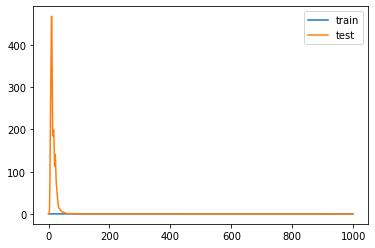

In [18]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

<div style="text-align: justify"> Nous pouvons voir que les résultats obtenus sont nettement supérieurs à ceux obtenus précédemment et nous paraissent, à première vue, satisfaisants. En effet, sur cette architecture la valeur de la fonction de perte est bien moins élevée que sur notre premier modèle. De plus, nous ne décelons aucune trace de sur-apprentissage. Pour nous assurer de cette première impression, nous avons voulu user de metriques pouvant confirmer notre analyse.</div>

## 5. Evaluation des performances de l'autoencodeur <a class="anchor" id="chapter5"></a>

<div style="text-align: justify"> Notre autoencodeur est capable de débruiter toute image, et cela avec un résultat convaincant à l'oeil nu. Evaluons à présent les performances de cet autoencodeur à l'aide de différentes métriques.
Pour l'évaluer et savoir si les images générées par ce dernier sont de qualité, nous allons utiliser des méthodes de comparaison d'images. Nous allons implémenter la <strong>MSE</strong> et le <strong>SSIM</strong>.</div>

- MSE : <div style="text-align: justify">Mean-square error ou erreur moyenne quadratique est un estimateur d'erreur traditionnel. La MSE mesure, dans notre cas, la différence moyenne au carré entre les images prédites et les images originales. Il suffit donc de calculer les différences entre les images pixel par pixel. Mais cela ne fonctionne bien que si nous voulons générer une image avec les meilleures couleurs de pixel conformes à l'image de base. Dans notre cas, nous voulons nous concentrer sur la structure ou le relief de l'image pour évaluer notre autoencodeur.</div>

Pour pallier ce problème, nous avons également implémenté le SSIM.

- SSIM : <div style="text-align: justify">Structural SIMilarity est une mesure de similarité entre deux images numériques. La SSIM est corrélée à la qualité et à la perception du système visuel humain. Au lieu d'utiliser les méthodes traditionnelles de sommation des erreurs, la SSIM modélise la distorsion de l'image comme une combinaison de trois facteurs qui sont la perte de corrélation, la distorsion de luminance et la distorsion de contraste.</div>

### 5.1 Implémentation de la MSE et du SSIM <a class="anchor" id="section_5_1"></a>

Nous utilisons trois images : 
- une image originale
- une image bruitée
- une image générée par l'autoencodeur depuis cette même image bruitée

In [20]:
mse_noise = mean_squared_error(x_test, x_test_noisy)
mse_const = mean_squared_error(x_test, predictions)

In [21]:
print(f'MSE entre l\'image originale et celle bruitée :  {mse_noise}')
print(f'MSE entre l\'image originale et celle générée :  {mse_const}')

MSE entre l'image originale et celle bruitée :  0.03053558035438986
MSE entre l'image originale et celle générée :  0.011412123017448619


In [22]:
ssim_noisy = ssim(x_test, x_test_noisy,data_range=x_test_noisy.max() - x_test_noisy.min(), multichannel=True)
ssim_denoised = ssim(x_test, predictions,data_range=predictions.max() - predictions.min(), multichannel=True)

In [23]:
print(f'SSIM entre l\'image originale et celle bruitée :  {ssim_noisy}')
print(f'SSIM entre l\'image originale et celle générée :  {ssim_denoised}')

SSIM entre l'image originale et celle bruitée :  0.7906284571496615
SSIM entre l'image originale et celle générée :  0.8981279902925041


### 5.2 Interprétation des résultats <a class="anchor" id="section_5_2"></a>

<div style="text-align: justify">Nous affichons les valeurs de MSE et de SSIM pour chacune de nos images. Le but étant d'avoir la MSE la plus proche de 0 et une valeur de SSIM la plus proche de 1 possible. Nous voyons donc que notre valeur de MSE pour notre image générée est de 0,01 donc proche de 0, cependant la MSE de l'image bruitée est de 0,03 donc nous ne pouvons pas nous baser sur cette valeur pour évaluer notre modèle.<br>
    
Voyons voir du coté du SSIM : <br> 
    
Nous avons une valeur moyenne de 0,90 pour l'image générée et une valeur moyenne de 0,79 pour l'image bruitée. Nous pouvons en conclure que, pour notre modèle, l'image générée est très similaire à l'image d'origine.</div>

## 6. Etude de cas <a class="anchor" id="chapter6"></a>

<div style="text-align: justify">Dans le but d'attester des bonnes performances de notre modèle nous avons décidé de réaliser une étude de cas. Nous nous centrerons sur le traitement d'une image bruitée que nous devrons importer et convertir dans le but de la rendre exploitable par le modèle. Nous passerons l'image bruitée en entrée de notre modèle et analyserons la sortie.</div>

### 6.1 Chargement de l'image bruitée <a class="anchor" id="section_6_1"></a>

<div style="text-align: justify">Dans un premier temps, nous devons importer notre image dans le notebook. Pour nous assurer de la véracité des résultats de notre étude nous avons choisi une image tirée d'internet préalablement bruitée. Le code ci-dessous appelle la fonction "prepocess" utilisée pour convertir et normaliser l'image en entrée.</div> 

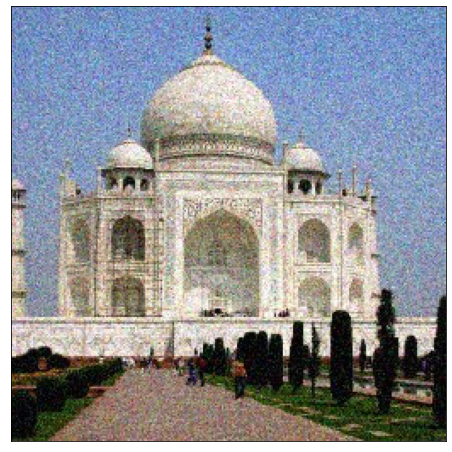

In [25]:
img = image.load_img("taj-rgb-noise.jpg", target_size=(256, 256))
img_convert = preprocess(img, is_batch = False)
display_image(img_convert, n=1, size = 8)

### 6.2 Débruitage de l'image <a class="anchor" id="section_6_2"></a>

<div style="text-align: justify">Nous allons pouvoir maintenant passer notre photo dans l'algorithme afin qu'elle puisse se faire débruiter. Pour ce faire, nous avons au préalable sauvegardé les poids de notre modèle dans le but d'optimiser le processus en termes de temps.</div>

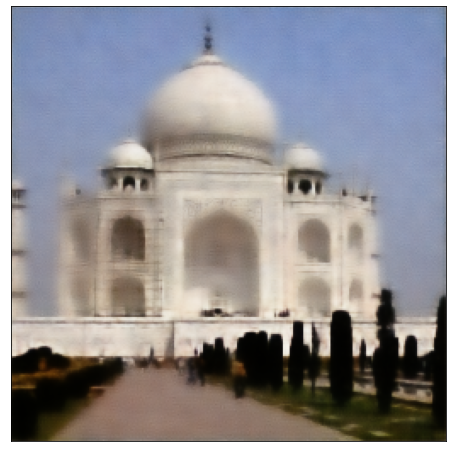

In [26]:
model_dir = pathlib.Path("models_improved//best_model.h5")
model = tf.keras.models.load_model(model_dir)
predictions = model.predict(img_convert)
display_image(predictions, 1, size=8)

<div style="text-align: justify">La sortie de notre DAE nous semble correcte. En effet, nous arrivons à reconnaître le Taj Mahal et distinguons le paysage environnant. Néanmoins, nous constatons une perte de précision par rapport à l'image initiale que nous avons quantifiée dans la partie <strong>5. Evaluation des performances de l'autoencodeur</strong>. Cette perte d'information se matérialise par l'apparition de flou sur la photo.</div>

## Conclusion <a class="anchor" id="chapter7"></a>

<div style="text-align: justify">L'objectif de ce notebook était de débruiter une image afin de la rendre utilisable par les algorithmes de Machine Learning. Pour ce faire nous avons pu nous reposer sur les acquis du livrable 1 en terme d'import de blibliothèques et d'utilisation du GPU. Néanmoins, pour préparer notre dataset il a fallu bruiter nos données pour pouvoir entraîner notre modèle. Suite à cela nous avons dû chercher un modèle qui correspond à notre problème et nos contraintes.</div><br>

<div style="text-align: justify">Notre choix s'est dirigé tout naturellement vers l'autoencodeur. Néanmoins, après avoir testé de nombreuses combinaisons de couche et de filtre, nos résultats n'étaient pas à la hauteur de nos attentes. Dans le but d'améliorer nos résultats, nous avons cherché et trouvé une architecture tirée de la littérature que nous avons implémenté. Les résultats qui en découlent sont bons et sont confirmés par notre étude de performance. Pour finir, nous avons décidé de réaliser une étude de cas pour attester nos résultats.</div>